# Velocity Inversion of Wave Equation by RNN NetWork

In [1]:
import torch
import sys
from torch import nn
from torch.nn import functional as F
from torch.nn import Module, Parameter
import numpy as np
import random as rd
import os
import math
from IPython import display

In [2]:
# source time function
def ricker(freq, length, dt, peak_time):
    """Return a Ricker wavelet with the specified central frequency.
    Args:
        freq: A float specifying the central frequency
        length: An int specifying the number of time samples
        dt: A float specifying the time sample spacing
        peak_time: A float specifying the time (in secs) of the peak amplitude
    """
    t = np.arange(0,length)*dt - peak_time
    y = (1-2*math.pi**2 * freq**2 * t**2) * np.exp(-math.pi**2 * freq**2 * t**2)
    return y

In [3]:
class RNNCell_FD(Module):
    def __init__(self, dx, dt, isrc, ir, nx, vel):
        super(RNNCell_FD, self).__init__()
        self.dx = dx          # grid point distance in x-direction
#         self.ir = ir          # receiver position in x-direction
#         self.isrc = isrc      # source position in x-direction
        self.nx = nx          # number of grid points in x-direction
        self.dt = dt          # sample delta
        kernel = [1/(dx**2), -2/(dx**2), 1/(dx**2)] # laplacian operator in space
        kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        # vel_init = vel**2 * self.dt  # the 1-D velocity model, vel: velocity(1-D tensor)
        vel_init = vel
        vel_init = vel_init.unsqueeze(0).unsqueeze(0)  # expend to 3-D tensor
        self.vel = Parameter(data=vel_init, requires_grad=True)
        self.weight_conv = Parameter(data=kernel, requires_grad=False)
        
        
    def forward(self, input, h_current, h_old, isrc, ir):
        ''' Forward calculating
        Args:
            input: the i-th value of source time function
            h_current: current wavefield
            h_old: previous wavefield
        '''
        self.ir = ir
        self.isrc = isrc
        if vel.shape[-1] != self.nx:
            # check the lenght of velocity model for nx
            print(f'[ERROR]: velocity model length {vel.shape[-1]} != {nx}!')
            os.system('PAUSE')
            
        # calculate space gradient
        d2px = F.conv1d(h_current, self.weight_conv)
        
        if d2px.shape[-1] != self.nx and (self.nx - d2px.shape[-1]) % 2 == 0:
            padd = int((self.nx - d2px.shape[-1]) / 2)
            d2pxx = F.pad(d2px, (padd, padd))   # padding the space gradient in order to have same dimension
            pure_d2px = d2pxx * self.vel * self.vel * self.dt * self.dt
        else:
            print(f'[ERROR]: Conv lenght {nx} - {d2px.shape[-1]} ={self.nx - d2px.shape[-1]} !')
            pure_d2px = d2px * self.vel * self.vel * self.dt * self.dt
        
        vel_value = torch.tensor(0.0, requires_grad=True)   # auxiliary tensor
        # local_vel = torch.sqrt(self.vel[0,0,-1] / self.dt) + vel_value # get the last point velocity of model
        local_vel = self.vel[0,0,-1] + vel_value
        if (local_vel - 0 < 0.01):
            print(f'local velcity: {local_vel}')
            sys.exit(1)
        
        # get the next wavefield
        h_next = pure_d2px - h_old + 2 * h_current
        # add source term:
        source_factor = torch.zeros(1,1,self.nx, requires_grad=True)   # auxiliary tensor
        source_factor_deta = source_factor.detach()
        source_factor_deta[0,0,self.isrc] = input * self.dt**2 * 1 / self.dx * self.vel[0,0,self.isrc]**2
        # h_next_plus_sr: the next wavefield
        h_next_plus_sr = h_next + source_factor

        
        #  boundary conditions
        # the fist point: open conditions
        value = h_next_plus_sr[0,0,-2] - 1/local_vel * (h_next_plus_sr[0,0,-2] - h_current[0,0,-2])*self.dx/self.dt
        ttmp = torch.zeros(1,1,self.nx, requires_grad=True)   # auxiliary tensor
        ttmp_deta = ttmp.detach()
        ttmp_deta[0,0,-1] = value
        tmp = torch.ones(1,1,self.nx, requires_grad=True)   # auxiliary tensor
        tmp_tmp = tmp.detach()
        tmp_tmp[0,0,-1] = 0
        h_next_plus_sr_bd = h_next_plus_sr * tmp + ttmp
        
        # the end point: fixed conditions
        tmp_zero = torch.ones(1,1,self.nx, requires_grad=True)
        tmp_zero_deta = tmp_zero.detach()
        tmp_zero_deta[0,0,0] = 0
        # h_next_plus_sr_bd_total: the next wavefield included source term and boundary conditions
        h_next_plus_sr_bd_total = h_next_plus_sr_bd * tmp_zero
        
        # get wavefield amplitude of the receiver position -> record
        delta_r = torch.zeros(nx,1,requires_grad=True)
        delta_r_d = delta_r.detach()
        delta_r_d[self.ir,0] = 1
        record = torch.mm(h_next_plus_sr_bd_total.squeeze(0), delta_r)

        # return current wavefield, next wavefield, amplitude of the receiver position
        return h_current, h_next_plus_sr_bd_total, record
        

In [4]:
dt = 0.001                     # delta
timeLen = 1                    # in second
nt = int(timeLen/dt)           # sample points
peak_freq = 10                  # in Hz
q0 = 1
peak_sorce_time = 1/peak_freq  #
source_amplitudes = q0 * ricker(peak_freq, nt, dt, peak_sorce_time)
src = source_amplitudes

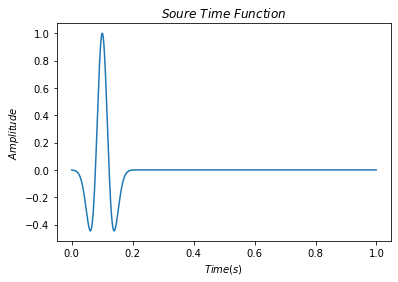

In [5]:
# plot source time function
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(np.arange(0,nt)*dt,source_amplitudes)
plt.xlabel('$Time(s)$')
plt.ylabel('$Amplitude$')
plt.title('$Soure\ Time\ Function$')
#plt.grid(ls='--')
plt.show()

[105  20  94  52 137 169  30 116 126  41 158 148  62  73  84 180]
[198 175  38  83  60 152 106 129]
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
2 0
2 1
2 2
2 3
torch.Size([1, 1, 200]) torch.Size([1, 1, 200])
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15


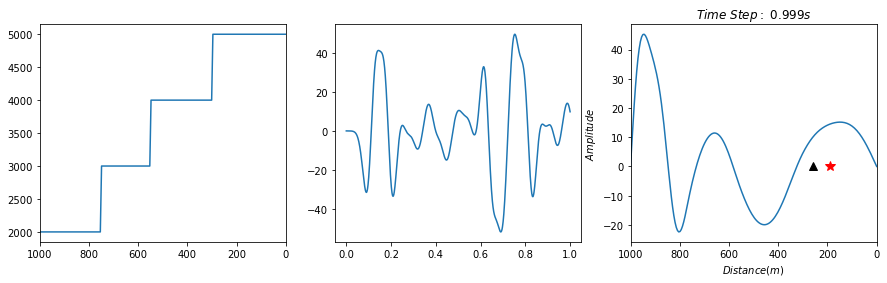

In [6]:
# 1D Wave Propagation (Finite Difference Solution)

nx   = 200         # number of grid points in x-direction
dx   = 5          # grid point distance in x-direction
isrc = 198          # source location in grid in x-direction
ir   = 180          # receiver location in grid in x-direction
mul_ir = np.linspace(180, 20, 16, dtype=int)
mul_isrc = np.linspace(198, 38, 8, dtype=int)
rd.shuffle(mul_ir)
rd.shuffle(mul_isrc)
print(mul_ir)
print(mul_isrc)

seis = torch.from_numpy(np.zeros((len(mul_isrc),len(mul_ir),nt)))              # receiver amplitude

vel = torch.cat((torch.ones(60)*5000, torch.ones(50)*4000, torch.ones(40)*3000, torch.ones(50)*2000))
vel_test1 = torch.cat((torch.ones(40)*5000, torch.linspace(5000,4000,30), 
                       torch.ones(30)*4000, torch.linspace(4000,3000,20), 
                       torch.ones(20)*3000, torch.linspace(3000,2000,30), 
                       torch.ones(30)*2000))
#vel_test = torch.from_numpy(sm_vel_new_value)
#vel_test = sm_vel_new_value
net = RNNCell_FD(dx, dt, isrc, ir, nx, vel)
net = net.float()
check_it = -1
for i, isrc_items in enumerate(torch.from_numpy(mul_isrc)):
    for indexs, ir_items in enumerate(torch.from_numpy(mul_ir)):
        h_current = torch.zeros(1,1,nx)  # current wavefield
        h_old = torch.zeros(1,1,nx)     # previous wavefield
        print(i, indexs)
        for it in range(nt):  # the time, from 0-th to nt-th wavefield
            # forward:
            h_old, h_current, record = net(src[it], h_current, h_old, isrc_items, ir_items)
            seis[i][indexs][it] = record
            if it == range(nt)[check_it] and i == 2 and indexs == 3: # plot the check_it-th wavefield
                print(h_old.shape, h_current.shape)
                plt.figure(figsize=(15,4))
                ax3 = plt.subplot(131)
                ax3.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy())
                ax3.set_xlim([0, nx*dx])
                ax3.invert_xaxis()

                ax1 = plt.subplot(132)
                time = np.linspace(0 * dt, nt * dt, nt)
                ax1.plot(time, seis[i, indexs, :].detach())

                ax2 = plt.subplot(133)
                ax2.plot(np.linspace(0 * dx, nx * dx, nx), h_current[0,0,:].detach().numpy())
                ax2.plot(isrc_items*dx, 0, 'r*', markersize=11) # source position
                ax2.plot(ir_items*dx, 0, 'k^', markersize=8) # receiver position
                ax2.set_xlim([0, nx*dx])
                ax2.set_xlabel('$Distance(m)$')
                ax2.set_ylabel('$Amplitude$')
                ax2.set_title(f'$Time\ Step:\ {it*dt}s$')
                ax2.invert_xaxis()
#                 plt.pause(0.5)
#                 display.clear_output(wait=True)


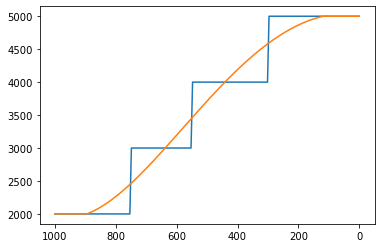

In [7]:
target = seis # inverstion target

# smoothing the true velocity model
N = 60
weights = np.hanning(N)
smooth_vel = np.convolve(weights/weights.sum(), vel.numpy(), 'same')
sm_vel_poly = np.polyfit(np.linspace(0 * dx, nx * dx, nx), vel.numpy(), 4)
sm_vel_value = np.polyval(sm_vel_poly, np.linspace(0 * dx, nx * dx, nx))

sm_vel_new_value = sm_vel_value
sm_vel_new_value[sm_vel_new_value>5000] = sm_vel_new_value[sm_vel_new_value>5000]*0+5000.
sm_vel_new_value[sm_vel_new_value<2000] = sm_vel_new_value[sm_vel_new_value<2000]*0+2000.

plt.figure()
ax_vel_true = plt.subplot(111)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy())
# ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), smooth_vel)
# ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), sm_vel_value)
# the initial velocity model
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), sm_vel_new_value)
ax_vel_true.invert_xaxis()

In [8]:
# init velocity
sm_vel_new_value = torch.from_numpy(sm_vel_new_value)

netInv = RNNCell_FD(dx, dt, isrc, ir, nx, sm_vel_new_value)
netInv = netInv.float()

In [9]:
optimizer = torch.optim.Adam(netInv.parameters(), lr=50)
loss_func = nn.MSELoss()

In [10]:
from torch.autograd import Variable

target = target.float()
total_loss = []
# with torch.autograd.set_detect_anomaly(True):
epoch = 200 # epoch: iterations
for step in range(epoch):
    seisInv = Variable(torch.zeros((len(mul_isrc), len(mul_ir),nt)))
    print(f'{step}/{epoch}:')
    for ii, isrc_items in enumerate(torch.from_numpy(mul_isrc)):
        for indexs, ir_items in enumerate(torch.from_numpy(mul_ir)): 
            # initialization
            h_current_Inv = Variable(torch.zeros(1,1,nx))
            h_old_Inv = Variable(torch.zeros(1,1,nx))
            for it in range(nt):
                # forward:
                h_old_Inv, h_current_Inv, seisInv[ii][indexs][it] = netInv(torch.tensor(src[it]), h_current_Inv, h_old_Inv, isrc_items, ir_items)
        #             h_old_Inv[it+1,...] = h_old_Inv[it+1,...].detach()
        #             h_current_Inv[it+1,...] = h_current_Inv[it+1,...].detach()
        #         if it == 0:
        #             total_seisInv = seisInv.unsqueeze(0)
        #             total_target = torch.cat((target[:(it+1)], torch.zeros(len(target)-len(target[:it+1])))).unsqueeze(0)
        #         else:
        #             total_seisInv = torch.cat((total_seisInv, seisInv.unsqueeze(0)),0)
        #             total_target = torch.cat((total_target, 
        #                                         torch.cat((target[:(it+1)], torch.zeros(len(target)-len(target[:it+1])))).unsqueeze(0)),0)

                #total_target = torch.cat((target[:(it+1)]), torch.zeros(len(target)-len(target[:it+1])))
    loss = loss_func(seisInv, target)
    total_loss.append(loss.data)
    optimizer.zero_grad()
#     loss.backward() # inverstion
    loss.backward(retain_graph=True)
    optimizer.step() # update velocity pamarmeter

    #plt.clf() # clear axis
    plt.figure(figsize=(13,5))
    plt.ion()
    plt.subplot(131)
    seisInvClone = seisInv.clone()
    plt.plot(np.linspace(0 * dt, nt * dt, nt), target.detach().numpy()[0][0], 'k')
    plt.plot(np.linspace(0 * dt, nt * dt, nt), seisInvClone.detach().numpy()[0][0])

    plt.subplot(132)
    pama = [x for x in netInv.parameters()]
    plt.plot(np.linspace(0 * dx, nx * dx, nx), vel.numpy(), 'k')
    pamaClone = pama[0].clone()
    for boolean in np.isnan(netInv.vel.grad.flatten().numpy()):
        if boolean:
            print(netInv.vel.grad)
            sys.exit(1)
    for boolean in np.isnan(pamaClone.detach()[0,0,:].numpy()):
        if boolean:
            for name, p in netInv.named_parameters():
                print(name, p)
            sys.exit(1)
    plt.plot(np.linspace(0 * dx, nx * dx, nx), pamaClone.detach()[0,0,:].numpy())

    plt.subplot(133)
    plt.plot(total_loss)
    plt.title(f'{step}')

    plt.tight_layout()
    plt.draw()
    plt.pause(3)
    display.clear_output(wait=True)
    plt.ioff()
    plt.show()

0/200:


KeyboardInterrupt: 

In [ ]:
%tb

SystemExit: 1

In [ ]:
for name, p in netInv.named_parameters():
    print(name, p)

vel Parameter containing:
tensor([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [ ]:
netInv.vel.grad # the velocity pamarmeter gradient
# for value in netInv.vel.grad.flatten():
#     print(value)

tensor(0.)
tensor(8.1269e-07)
tensor(3.2316e-06)
tensor(7.1993e-06)
tensor(1.2622e-05)
tensor(1.9371e-05)
tensor(2.7290e-05)
tensor(3.6193e-05)
tensor(4.5875e-05)
tensor(5.6114e-05)
tensor(6.6677e-05)
tensor(7.7330e-05)
tensor(8.7838e-05)
tensor(9.7971e-05)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(9.8682e-05)
tensor(8.8150e-05)
tensor(7.6988e-05)
tensor(6.5392e-05)
tensor(5.3582e-05)
tensor(4.1775e-05)
tensor(3.0201e-05)
tensor(1.9102e-05)
tensor(0.0018)
tensor(-6.7610e-06)
tensor(-2.0997e-05)
tensor(-3.3684e-05)
tensor(-4.4559e-05)
tensor(-5.3223e-05)
tensor(-5.9429e-05)
tensor(-6.2975e-05)
tensor(-6.3705e-05)
tensor(-6.1518e-05)
tensor(-5.6377e-05)
tensor(-4.8310e-05)
tensor(-3.7413e-05)
tensor(-2.3850e-05)
tensor(-7.8568e-06)
tensor(1.1293e-05)
tensor(3.2364e-05)
tensor(5.4924e-05